# Statistcal anaysis of sensor data

In [1]:
# statistcal inference

from functools import partial

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa, analysis:ignore

import mne
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,
                       permutation_t_test, permutation_cluster_1samp_test)

hypothesis testing

In [2]:
width = 40
n_subjects = 10
signal_mean = 100
signal_sd = 100
noise_sd = 0.01
gaussian_sd = 5
sigma = 1e-3  # sigma for the "hat" method
n_permutations = 'all'  # run an exact test
n_src = width * width

# For each "subject", make a smoothed noisy signal with a centered peak
rng = np.random.RandomState(2)
X = noise_sd * rng.randn(n_subjects, width, width)
# Add a signal at the center
X[:, width // 2, width // 2] = signal_mean + rng.randn(n_subjects) * signal_sd
# Spatially smooth with a 2D Gaussian kernel
size = width // 2 - 1
gaussian = np.exp(-(np.arange(-size, size + 1) ** 2 / float(gaussian_sd ** 2)))
for si in range(X.shape[0]):
    for ri in range(X.shape[1]):
        X[si, ri, :] = np.convolve(X[si, ri, :], gaussian, 'same')
    for ci in range(X.shape[2]):
        X[si, :, ci] = np.convolve(X[si, :, ci], gaussian, 'same')

[[], [], Text(0.5, 1.0, 'Data averaged over subjects')]

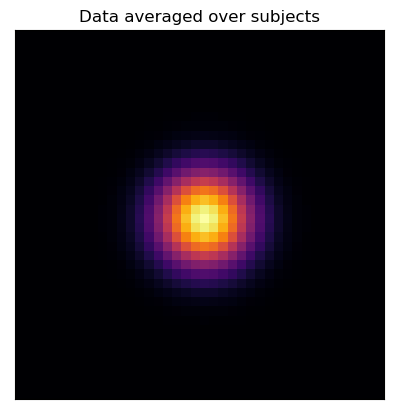

In [3]:
fig, ax = plt.subplots()
ax.imshow(X.mean(0), cmap='inferno')
ax.set(xticks=[], yticks=[], title="Data averaged over subjects")

null hypothesis:There is no difference between the mean value and zero (
H
0
:
μ
=
0
).
This is a two-tailed test because the mean could be less than or greater than zero, whereas a one-tailed test would test only one of these possibilities, i.e. 
H
1
:
μ
≥
0
 or 
H
1
:
μ
≤
0
.

parametric tests

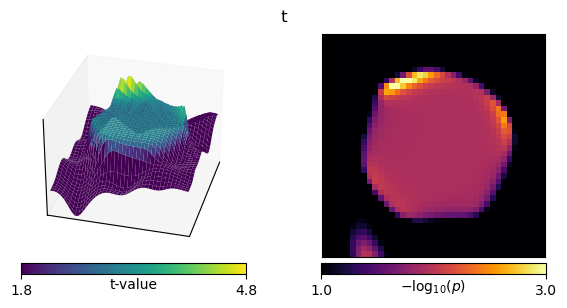

In [16]:
titles = ['t']
out = stats.ttest_1samp(X, 0, axis=0)
ts = [out[0]]
ps = [out[1]]
mccs = [False]  # these are not multiple-comparisons corrected


def plot_t_p(t, p, title, mcc, axes=None):
    if axes is None:
        fig = plt.figure(figsize=(6, 3))
        axes = [fig.add_subplot(121, projection='3d'), fig.add_subplot(122)]
        show = True
    else:
        show = False

    # calculate critical t-value thresholds (2-tailed)
    p_lims = np.array([0.1, 0.001])
    df = n_subjects - 1  # degrees of freedom
    t_lims = stats.distributions.t.ppf(1 - p_lims / 2, df=df)
    p_lims = [-np.log10(p) for p in p_lims]

    # t plot
    x, y = np.mgrid[0:width, 0:width]
    surf = axes[0].plot_surface(x, y, np.reshape(t, (width, width)),
                                rstride=1, cstride=1, linewidth=0,
                                vmin=t_lims[0], vmax=t_lims[1], cmap='viridis')
    axes[0].set(xticks=[], yticks=[], zticks=[],
                xlim=[0, width - 1], ylim=[0, width - 1])
    axes[0].view_init(30, 15)
    cbar = plt.colorbar(ax=axes[0], shrink=0.75, orientation='horizontal',
                        fraction=0.1, pad=0.025, mappable=surf)
    cbar.set_ticks(t_lims)
    cbar.set_ticklabels(['%0.1f' % t_lim for t_lim in t_lims])
    cbar.set_label('t-value')
    cbar.ax.get_xaxis().set_label_coords(0.5, -0.3)
    if not show:
        axes[0].set(title=title)
        if mcc:
            axes[0].title.set_weight('bold')
    # p plot
    use_p = -np.log10(np.reshape(np.maximum(p, 1e-5), (width, width)))
    img = axes[1].imshow(use_p, cmap='inferno', vmin=p_lims[0], vmax=p_lims[1],
                         interpolation='nearest')
    axes[1].set(xticks=[], yticks=[])
    cbar = plt.colorbar(ax=axes[1], shrink=0.75, orientation='horizontal',
                        fraction=0.1, pad=0.025, mappable=img)
    cbar.set_ticks(p_lims)
    cbar.set_ticklabels(['%0.1f' % p_lim for p_lim in p_lims])
    cbar.set_label(r'$-\log_{10}(p)$')
    cbar.ax.get_xaxis().set_label_coords(0.5, -0.3)
    if show:
        text = fig.suptitle(title)
        if mcc:
            text.set_weight('bold')
        plt.subplots_adjust(0, 0.05, 1, 0.9, wspace=0, hspace=0)
        mne.viz.utils.plt_show()


plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

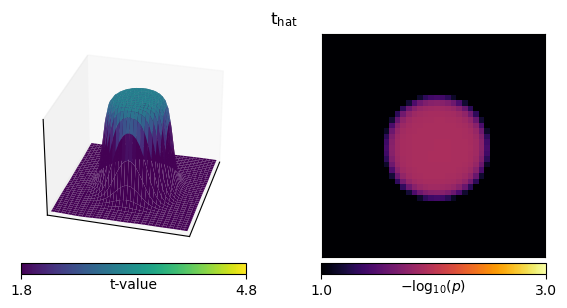

In [17]:
# hat variacne adjustment  - regularization

ts.append(ttest_1samp_no_p(X, sigma=sigma))
ps.append(stats.distributions.t.sf(np.abs(ts[-1]), len(X) - 1) * 2)
titles.append(r'$\mathrm{t_{hat}}$')
mccs.append(False)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

non-parametric tests

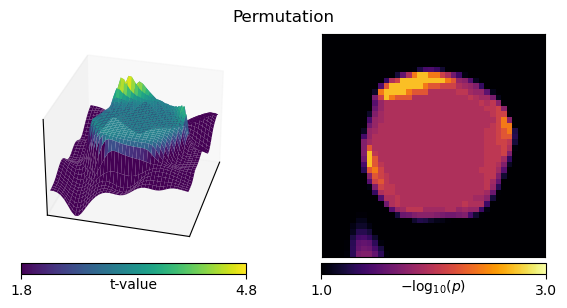

In [18]:
# permutation test

# Here we have to do a bit of gymnastics to get our function to do
# a permutation test without correcting for multiple comparisons:

X.shape = (n_subjects, n_src)  # flatten the array for simplicity
titles.append('Permutation')
ts.append(np.zeros(width * width))
ps.append(np.zeros(width * width))
mccs.append(False)
for ii in range(n_src):
    ts[-1][ii], ps[-1][ii] = permutation_t_test(X[:, [ii]], verbose=False)[:2]
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_5164/2318245221.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


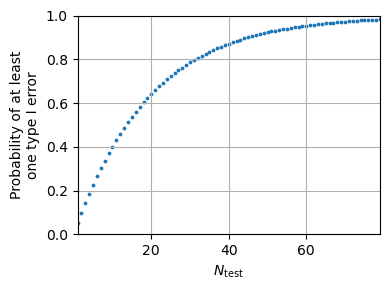

In [23]:
N = np.arange(1, 80)
alpha = 0.05
p_type_I = 1 - (1 - alpha) ** N
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(N, p_type_I, 3)
ax.set(xlim=N[[0, -1]], ylim=[0, 1], xlabel=r'$N_{\mathrm{test}}$',
       ylabel=u'Probability of at least\none type I error')
ax.grid(True)
fig.tight_layout()
fig.show()

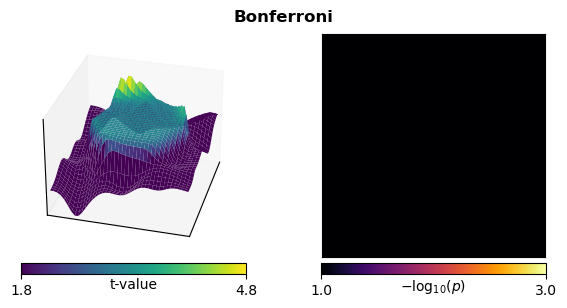

In [24]:
titles.append('Bonferroni')
ts.append(ts[-1])
ps.append(bonferroni_correction(ps[0])[1])
mccs.append(True)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

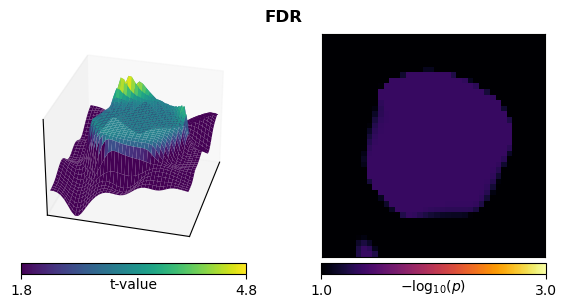

In [25]:
# False discovery rate(FDR ) correction, less strict control of type 1 error

titles.append('FDR')
ts.append(ts[-1])
ps.append(fdr_correction(ps[0])[1])
mccs.append(True)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

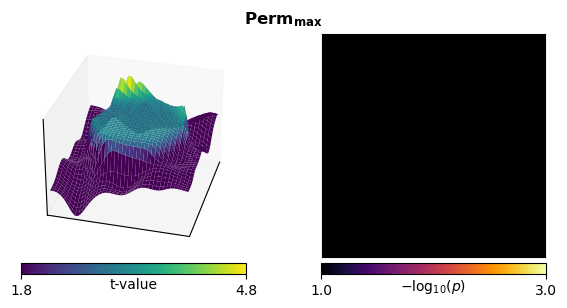

In [26]:
titles.append(r'$\mathbf{Perm_{max}}$')
out = permutation_t_test(X, verbose=False)[:2]
ts.append(out[0])
ps.append(out[1])
mccs.append(True)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

In [27]:
from sklearn.feature_extraction.image import grid_to_graph  # noqa: E402
mini_adjacency = grid_to_graph(3, 3).toarray()
assert mini_adjacency.shape == (9, 9)
print(mini_adjacency[0])

[1 1 0 1 0 0 0 0 0]


In [28]:
builtin_ch_adj = mne.channels.get_builtin_ch_adjacencies(descriptions=True)
for adj_name, adj_description in builtin_ch_adj:
    print(f'{adj_name}: {adj_description}')

biosemi16: Biosemi 16-electrode cap
biosemi32: Biosemi 32-electrode cap
biosemi64: Biosemi 64-electrode cap
bti148: BTI 148-channel system
bti248: BTI 248-channel system
bti248grad: BTI 248 gradiometer system
ctf151: CTF 151 axial gradiometer
ctf275: CTF 275 axial gradiometer
ctf64: CTF 64 axial gradiometer
easycap128ch-avg: 
easycap32ch-avg: 
easycap64ch-avg: 
easycapM1: Easycap M1
easycapM11: Easycap M11
easycapM14: Easycap M14
easycapM15: Easycap M15
ecog256: ECOG 256channels, average referenced
ecog256bipolar: ECOG 256channels, bipolar referenced
eeg1010_neighb: 
elec1005: Standard 10-05 system
elec1010: Standard 10-10 system
elec1020: Standard 10-20 system
itab153: ITAB 153-channel system
itab28: ITAB 28-channel system
KIT-157: 
KIT-208: 
KIT-NYU-2019: 
KIT-UMD-1: 
KIT-UMD-2: 
KIT-UMD-3: 
KIT-UMD-4: 
language29ch-avg: MPI for Psycholinguistic: Averaged 29-channel cap
mpi_59_channels: MPI for Psycholinguistic: 59-channel cap
neuromag122cmb: Neuromag122, only combined planar gradiom

stat_fun(H1): min=-3.195527 max=5.120434
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/510 [00:00<?,       ?it/s]

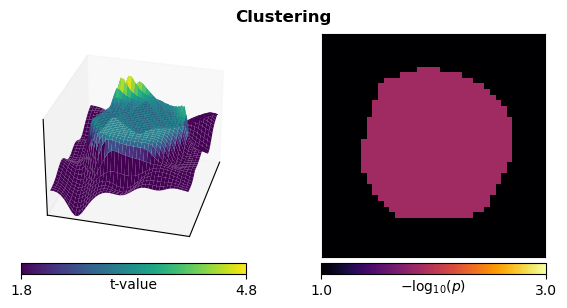

In [29]:
titles.append('Clustering')

# Reshape data to what is equivalent to (n_samples, n_space, n_time)
X.shape = (n_subjects, width, width)

# Compute threshold from t distribution (this is also the default)
# Here we use a two-tailed test, hence we need to divide alpha by 2.
# Subtracting alpha from 1 guarantees that we get a positive threshold,
# which MNE-Python expects for two-tailed tests.
df = n_subjects - 1  # degrees of freedom
t_thresh = stats.distributions.t.ppf(1 - alpha / 2, df=df)

# run the cluster test
t_clust, clusters, p_values, H0 = permutation_cluster_1samp_test(
    X, n_jobs=None, threshold=t_thresh, adjacency=None,
    n_permutations=n_permutations, out_type='mask')

# Put the cluster data in a viewable format
p_clust = np.ones((width, width))
for cl, p in zip(clusters, p_values):
    p_clust[cl] = p
ts.append(t_clust)
ps.append(p_clust)
mccs.append(True)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

stat_fun(H1): min=-0.043603 max=3.127369
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/510 [00:00<?,       ?it/s]

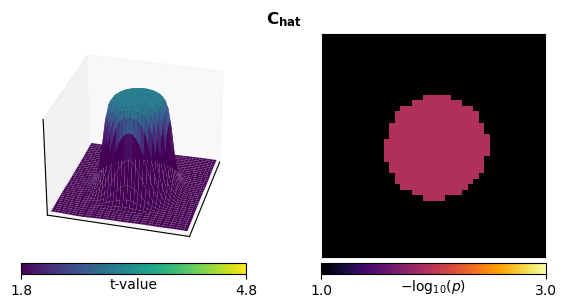

In [30]:
# 'hat ' variance adjustment

titles.append(r'$\mathbf{C_{hat}}$')
stat_fun_hat = partial(ttest_1samp_no_p, sigma=sigma)
t_hat, clusters, p_values, H0 = permutation_cluster_1samp_test(
    X, n_jobs=None, threshold=t_thresh, adjacency=None, out_type='mask',
    n_permutations=n_permutations, stat_fun=stat_fun_hat, buffer_size=None)
p_hat = np.ones((width, width))
for cl, p in zip(clusters, p_values):
    p_hat[cl] = p
ts.append(t_hat)
ps.append(p_hat)
mccs.append(True)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

stat_fun(H1): min=-3.195527 max=5.120434
Running initial clustering …
Using 26 thresholds from 0.00 to 5.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 1600 clusters


  0%|          | Permuting : 0/510 [00:00<?,       ?it/s]

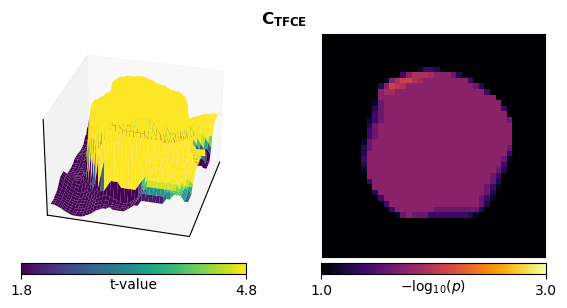

In [31]:
# threshold free clustering enhancement (TFCE)

titles.append(r'$\mathbf{C_{TFCE}}$')
threshold_tfce = dict(start=0, step=0.2)
t_tfce, _, p_tfce, H0 = permutation_cluster_1samp_test(
    X, n_jobs=None, threshold=threshold_tfce, adjacency=None,
    n_permutations=n_permutations, out_type='mask')
ts.append(t_tfce)
ps.append(p_tfce)
mccs.append(True)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

stat_fun(H1): min=-0.043603 max=3.127369
Running initial clustering …
Using 16 thresholds from 0.00 to 3.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 1600 clusters


  0%|          | Permuting : 0/510 [00:00<?,       ?it/s]

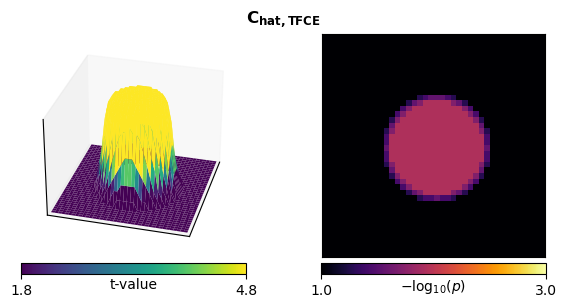

In [32]:
titles.append(r'$\mathbf{C_{hat,TFCE}}$')
t_tfce_hat, _, p_tfce_hat, H0 = permutation_cluster_1samp_test(
    X, n_jobs=None, threshold=threshold_tfce, adjacency=None, out_type='mask',
    n_permutations=n_permutations, stat_fun=stat_fun_hat, buffer_size=None)
ts.append(t_tfce_hat)
ps.append(p_tfce_hat)
mccs.append(True)
plot_t_p(ts[-1], ps[-1], titles[-1], mccs[-1])

In [ ]:
# visualize and compare methods

ValueError: num must be 1 <= num <= 20, not 21

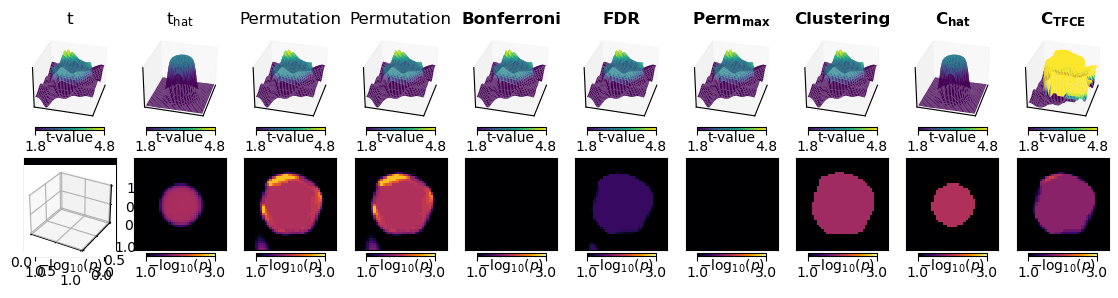

In [35]:
fig = plt.figure(facecolor='w', figsize=(14, 3))
assert len(ts) == len(titles) == len(ps)
for ii in range(len(ts)):
    ax = [fig.add_subplot(2, 10, ii + 1, projection='3d'),
          fig.add_subplot(2, 10, 11 + ii)]
    plot_t_p(ts[ii], ps[ii], titles[ii], mccs[ii], ax)
fig.tight_layout(pad=0, w_pad=0.05, h_pad=0.1)
plt.show()

The first three columns show the parametric and non-parametric statistics that are not corrected for multiple comparisons:

Mass univariate t-tests result in jagged edges.
“Hat” variance correction of the t-tests produces less peaky edges, correcting for sharpness in the statistic driven by low-variance voxels.
Non-parametric resampling tests are very similar to t-tests. This is to be expected: the data are drawn from a Gaussian distribution, and thus satisfy parametric assumptions.

The next three columns show multiple comparison corrections of the mass univariate tests (parametric and non-parametric). These too conservatively correct for multiple comparisons because neighboring voxels in our data are correlated:

Bonferroni correction eliminates any significant activity.
FDR correction is less conservative than Bonferroni.
A permutation test with a maximum statistic also eliminates any significant activity.

The final four columns show the non-parametric cluster-based permutation tests with a maximum statistic:

Standard clustering identifies the correct region. However, the whole area must be declared significant, so no peak analysis can be done. Also, the peak is broad.
Clustering with “hat” variance adjustment tightens the estimate of significant activity.
Clustering with TFCE allows analyzing each significant point independently, but still has a broadened estimate.
Clustering with TFCE and “hat” variance adjustment tightens the area declared significant (again FWER corrected).

In [36]:
# visualizing statistical significant thresholds on EEG data

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import mne
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test

np.random.seed(0)

# Load the data
path = mne.datasets.kiloword.data_path() / 'kword_metadata-epo.fif'
epochs = mne.read_epochs(path)
# These data are quite smooth, so to speed up processing we'll (unsafely!) just
# decimate them
epochs.decimate(4, verbose='error')
name = "NumberOfLetters"

# Split up the data by the median length in letters via the attached metadata
median_value = str(epochs.metadata[name].median())
long_words = epochs[name + " > " + median_value]
short_words = epochs[name + " < " + median_value]

Reading /Users/DanDan/mne_data/MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
960 matching events found
No baseline correction applied
0 projection items activated


In [46]:
time_windows = ((.2, .25), (.35, .45))
elecs = ["Fz", "Cz", "Pz"]
index = ['condition', 'epoch', 'time']

# display the EEG data in Pandas format (first 5 rows)
print(epochs.to_data_frame(index=index)[elecs].head())

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")
for (tmin, tmax) in time_windows:
    long_df = long_words.copy().crop(tmin, tmax).to_data_frame(index=index)
    short_df = short_words.copy().crop(tmin, tmax).to_data_frame(index=index)
    for elec in elecs:
        # extract data
        A = long_df[elec].groupby("condition").mean()
        B = short_df[elec].groupby("condition").mean()

        # conduct t test
        t, p = ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(epochs.events) - 2, t_val=t, p=p)
        print(report.format(**format_dict))

channel                       Fz        Cz        Pz
condition epoch time                                
film      0     -0.096  0.453939  0.232879  0.222424
                -0.080  0.518939  0.214091 -0.371515
                -0.064  0.811667  0.793636  0.250152
                -0.048  0.039697  0.188636  0.318030
                -0.032 -1.163030 -1.018939 -0.425152

Targeted statistical test results:
Fz, time: 0.2-0.25 s; t(958)=-0.661, p=0.509
Cz, time: 0.2-0.25 s; t(958)=-2.682, p=0.007
Pz, time: 0.2-0.25 s; t(958)=-3.238, p=0.001
Fz, time: 0.35-0.45 s; t(958)=5.304, p=0.000
Cz, time: 0.35-0.45 s; t(958)=5.684, p=0.000
Pz, time: 0.35-0.45 s; t(958)=6.508, p=0.000


In [47]:
# TFCE

# Calculate adjacency matrix between sensors from their locations
adjacency, _ = find_ch_adjacency(epochs.info, "eeg")

# Extract data: transpose because the cluster test requires channels to be last
# In this case, inference is done over items. In the same manner, we could
# also conduct the test over, e.g., subjects.
X = [long_words.get_data().transpose(0, 2, 1),
     short_words.get_data().transpose(0, 2, 1)]
tfce = dict(start=.4, step=.4)  # ideally start and step would be smaller

# Calculate statistical thresholds
t_obs, clusters, cluster_pv, h0 = spatio_temporal_cluster_test(
    X, tfce, adjacency=adjacency,
    n_permutations=100)  # a more standard number would be 1000+
significant_points = cluster_pv.reshape(t_obs.shape).T < .05
print(str(significant_points.sum()) + " points selected by TFCE ...")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 29
stat_fun(H1): min=0.000001 max=80.917298
Running initial clustering …
Using 202 thresholds from 0.40 to 80.80 for TFCE computation (h_power=2.00, e_power=0.50)
Found 1856 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

362 points selected by TFCE ...


No projector specified for this dataset. Please consider the method self.add_proj.


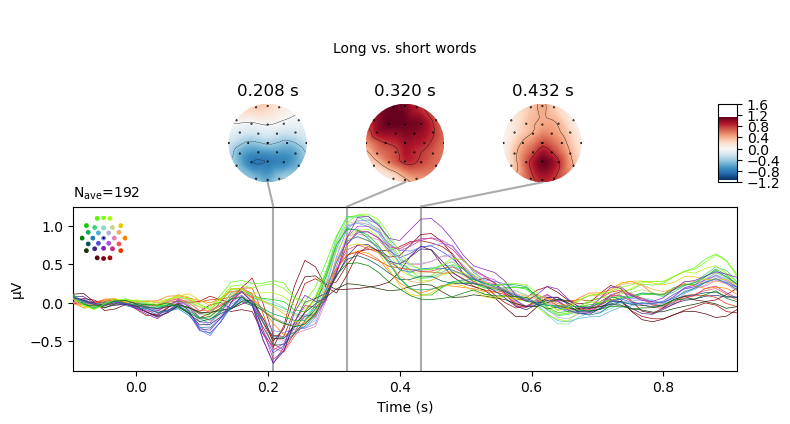

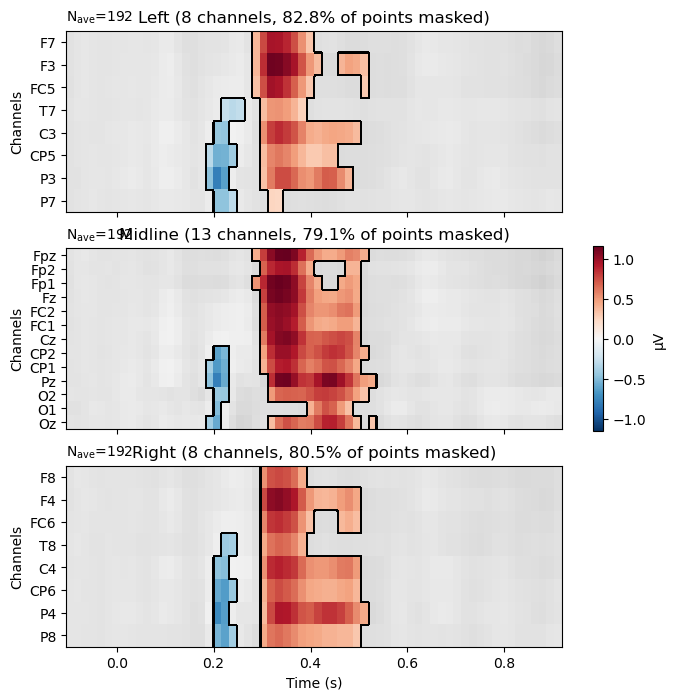

In [48]:
# We need an evoked object to plot the image to be masked
evoked = mne.combine_evoked([long_words.average(), short_words.average()],
                            weights=[1, -1])  # calculate difference wave
time_unit = dict(time_unit="s")
evoked.plot_joint(title="Long vs. short words", ts_args=time_unit,
                  topomap_args=time_unit)  # show difference wave

# Create ROIs by checking channel labels
selections = make_1020_channel_selections(evoked.info, midline="12z")

# Visualize the results
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
evoked.plot_image(axes=axes, group_by=selections, colorbar=False, show=False,
                  mask=significant_points, show_names="all", titles=None,
                  **time_unit)
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=.3,
             label="µV")

plt.show()

##  non-parametric 1 sample cluster statsitic

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_1samp_test
from mne.datasets import sample

In [50]:
data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_raw.fif'
tmin, tmax, event_id = -0.3, 0.6, 1

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')

include = []
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True,
                       stim=False, include=include, exclude='bads')

# Load condition 1
event_id = 1
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6))

# just use right temporal sensors for speed
epochs.pick_channels(mne.read_vectorview_selection('Right-temporal'))
evoked = epochs.average()

# Factor to down-sample the temporal dimension of the TFR computed by
# tfr_morlet. Decimation occurs after frequency decomposition and can
# be used to reduce memory usage (and possibly computational time of downstream
# operations such as nonparametric statistics) if you don't need high
# spectrotemporal resolution.
decim = 5

# define frequencies of interest
freqs = np.arange(8, 40, 2)

# run the TFR decomposition
tfr_epochs = tfr_morlet(epochs, freqs, n_cycles=4., decim=decim,
                        average=False, return_itc=False, n_jobs=None)

# Baseline power
tfr_epochs.apply_baseline(mode='logratio', baseline=(-.100, 0))

# Crop in time to keep only what is between 0 and 400 ms
evoked.crop(-0.1, 0.4)
tfr_epochs.crop(-0.1, 0.4)

epochs_power = tfr_epochs.data

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] sec
Applying baseline correction (mode: mean)
3 projection items activated
Loading data for 72 events and 541 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.0s finished


In [51]:
# find_ch_adjacency first attempts to find an existing "neighbor"
# (adjacency) file for given sensor layout.
# If such a file doesn't exist, an adjacency matrix is computed on the fly,
# using Delaunay triangulations.
sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(
    tfr_epochs.info, 'grad')

# In this case, find_ch_adjacency finds an appropriate file and
# reads it (see log output: "neuromag306planar").
# However, we need to subselect the channels we are actually using
use_idx = [ch_names.index(ch_name)
           for ch_name in tfr_epochs.ch_names]
sensor_adjacency = sensor_adjacency[use_idx][:, use_idx]

# Our sensor adjacency matrix is of shape n_chs × n_chs
assert sensor_adjacency.shape == \
    (len(tfr_epochs.ch_names), len(tfr_epochs.ch_names))

# Now we need to prepare adjacency information for the time-frequency
# plane. For that, we use "combine_adjacency", and pass dimensions
# as in the data we want to test (excluding observations). Here:
# channels × frequencies × times
assert epochs_power.data.shape == (
    len(epochs), len(tfr_epochs.ch_names),
    len(tfr_epochs.freqs), len(tfr_epochs.times))
adjacency = mne.stats.combine_adjacency(
    sensor_adjacency, len(tfr_epochs.freqs), len(tfr_epochs.times))

# The overall adjacency we end up with is a square matrix with each
# dimension matching the data size (excluding observations) in an
# "unrolled" format, so: len(channels × frequencies × times)
assert adjacency.shape[0] == adjacency.shape[1] == \
    len(tfr_epochs.ch_names) * len(tfr_epochs.freqs) * len(tfr_epochs.times)

Reading adjacency matrix for neuromag306planar.


In [52]:
# We want a two-tailed test
tail = 0

# In this example, we wish to set the threshold for including data bins in
# the cluster forming process to the t-value corresponding to p=0.001 for the
# given data.
#
# Because we conduct a two-tailed test, we divide the p-value by 2 (which means
# we're making use of both tails of the distribution).
# As the degrees of freedom, we specify the number of observations
# (here: epochs) minus 1.
# Finally, we subtract 0.001 / 2 from 1, to get the critical t-value
# on the right tail (this is needed for MNE-Python internals)
degrees_of_freedom = len(epochs) - 1
t_thresh = scipy.stats.t.ppf(1 - 0.001 / 2, df=degrees_of_freedom)

# Set the number of permutations to run.
# Warning: 50 is way too small for a real-world analysis (where values of 5000
# or higher are used), but here we use it to increase the computation speed.
n_permutations = 50

# Run the analysis
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(epochs_power, n_permutations=n_permutations,
                                   threshold=t_thresh, tail=tail,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True)

stat_fun(H1): min=-6.455144 max=8.265125
Running initial clustering …
Found 47 clusters


  0%|          | Permuting : 0/49 [00:00<?,       ?it/s]

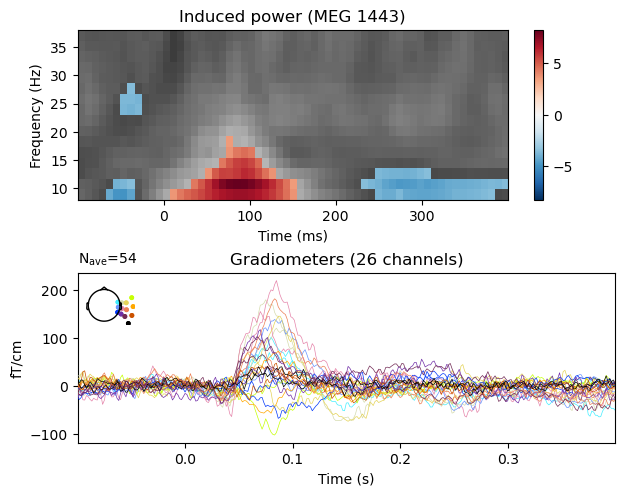

In [53]:
evoked_data = evoked.data
times = 1e3 * evoked.times

plt.figure()
plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

T_obs_plot = np.nan * np.ones_like(T_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_plot[c] = T_obs[c]

# Just plot one channel's data
# use the following to show a specific one:
# ch_idx = tfr_epochs.ch_names.index('MEG 1332')
ch_idx, f_idx, t_idx = np.unravel_index(
    np.nanargmax(np.abs(T_obs_plot)), epochs_power.shape[1:])

vmax = np.max(np.abs(T_obs))
vmin = -vmax
plt.subplot(2, 1, 1)
plt.imshow(T_obs[ch_idx], cmap=plt.cm.gray,
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.imshow(T_obs_plot[ch_idx], cmap=plt.cm.RdBu_r,
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Induced power ({tfr_epochs.ch_names[ch_idx]})')

ax2 = plt.subplot(2, 1, 2)
evoked.plot(axes=[ax2], time_unit='s')
plt.show()

# non-parametric between conditions cluster statistic on single trail power

In [54]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet
from mne.stats import permutation_cluster_test
from mne.datasets import sample

print(__doc__)

Automatically created module for IPython interactive environment


In [55]:
data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_raw.fif'
event_fname = meg_path / 'sample_audvis_raw-eve.fif'
tmin, tmax = -0.2, 0.5

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.read_events(event_fname)

include = []
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True,
                       stim=False, include=include, exclude='bads')

ch_name = 'MEG 1332'  # restrict example to one channel

# Load condition 1
reject = dict(grad=4000e-13, eog=150e-6)
event_id = 1
epochs_condition_1 = mne.Epochs(raw, events, event_id, tmin, tmax,
                                picks=picks, baseline=(None, 0),
                                reject=reject, preload=True)
epochs_condition_1.pick_channels([ch_name])

# Load condition 2
event_id = 2
epochs_condition_2 = mne.Epochs(raw, events, event_id, tmin, tmax,
                                picks=picks, baseline=(None, 0),
                                reject=reject, preload=True)
epochs_condition_2.pick_channels([ch_name])

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
3 projection items activated
Loading data for 72 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EO

Number of events,60
Events,2: 60
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


In [56]:
decim = 2
freqs = np.arange(7, 30, 3)  # define frequencies of interest
n_cycles = 1.5

tfr_epochs_1 = tfr_morlet(epochs_condition_1, freqs,
                          n_cycles=n_cycles, decim=decim,
                          return_itc=False, average=False)

tfr_epochs_2 = tfr_morlet(epochs_condition_2, freqs,
                          n_cycles=n_cycles, decim=decim,
                          return_itc=False, average=False)

tfr_epochs_1.apply_baseline(mode='ratio', baseline=(None, 0))
tfr_epochs_2.apply_baseline(mode='ratio', baseline=(None, 0))

epochs_power_1 = tfr_epochs_1.data[:, 0, :, :]  # only 1 channel as 3D matrix
epochs_power_2 = tfr_epochs_2.data[:, 0, :, :]  # only 1 channel as 3D matrix

Not setting metadata
Not setting metadata
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [57]:
threshold = 6.0
F_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([epochs_power_1, epochs_power_2], out_type='mask',
                             n_permutations=100, threshold=threshold, tail=0)

stat_fun(H1): min=0.000000 max=13.566824
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

In [58]:
threshold = 6.0
F_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([epochs_power_1, epochs_power_2], out_type='mask',
                             n_permutations=100, threshold=threshold, tail=0)

stat_fun(H1): min=0.000000 max=13.566824
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Need more than one channel to make topography for grad. Disabling interactivity.


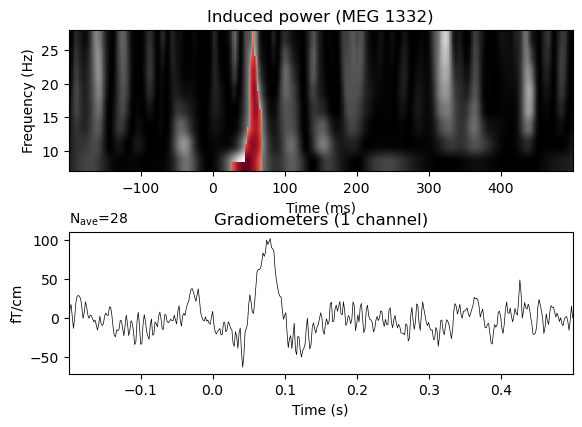

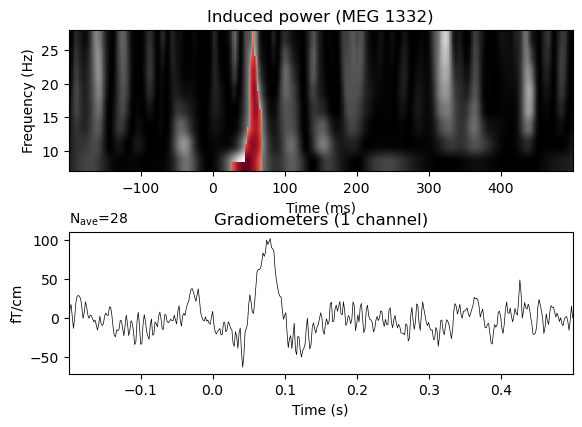

In [59]:
times = 1e3 * epochs_condition_1.times  # change unit to ms

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

# Compute the difference in evoked to determine which was greater since
# we used a 1-way ANOVA which tested for a difference in population means
evoked_power_1 = epochs_power_1.mean(axis=0)
evoked_power_2 = epochs_power_2.mean(axis=0)
evoked_power_contrast = evoked_power_1 - evoked_power_2
signs = np.sign(evoked_power_contrast)

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        F_obs_plot[c] = F_obs[c] * signs[c]

ax.imshow(F_obs,
          extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower', cmap='gray')
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(F_obs_plot,
          extent=[times[0], times[-1], freqs[0], freqs[-1]],
          aspect='auto', origin='lower', cmap='RdBu_r',
          vmin=-max_F, vmax=max_F)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Induced power ({ch_name})')

# plot evoked
evoked_condition_1 = epochs_condition_1.average()
evoked_condition_2 = epochs_condition_2.average()
evoked_contrast = mne.combine_evoked([evoked_condition_1, evoked_condition_2],
                                     weights=[1, -1])
evoked_contrast.plot(axes=ax2, time_unit='s')

# mass-univariate 2 way repetead measures ANOVA on signal trail power

In [60]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet
from mne.stats import f_threshold_mway_rm, f_mway_rm, fdr_correction
from mne.datasets import sample

print(__doc__)

Automatically created module for IPython interactive environment


In [61]:
data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_raw.fif'
event_fname = meg_path / 'sample_audvis_raw-eve.fif'
tmin, tmax = -0.2, 0.5

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.read_events(event_fname)

include = []
raw.info['bads'] += ['MEG 2443']  # bads

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True,
                       stim=False, include=include, exclude='bads')

ch_name = 'MEG 1332'

# Load conditions
reject = dict(grad=4000e-13, eog=150e-6)
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    picks=picks, baseline=(None, 0), preload=True,
                    reject=reject)
epochs.pick_channels([ch_name])  # restrict example to one channel

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Not setting metadata
289 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
3 projection items activated
Loading data for 289 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on 

Number of events,236
Events,aud_l: 56aud_r: 60vis_l: 64vis_r: 56
Time range,-0.200 – 0.499 sec
Baseline,-0.200 – 0.000 sec


In [62]:
epochs.equalize_event_counts(event_id)

# Factor to down-sample the temporal dimension of the TFR computed by
# tfr_morlet.
decim = 2
freqs = np.arange(7, 30, 3)  # define frequencies of interest
n_cycles = freqs / freqs[0]
zero_mean = False  # don't correct morlet wavelet to be of mean zero
# To have a true wavelet zero_mean should be True but here for illustration
# purposes it helps to spot the evoked response.

Dropped 12 epochs: 50, 92, 128, 147, 152, 154, 155, 186, 196, 198, 206, 207


In [63]:
epochs_power = list()
for condition in [epochs[k] for k in event_id]:
    this_tfr = tfr_morlet(condition, freqs, n_cycles=n_cycles,
                          decim=decim, average=False, zero_mean=zero_mean,
                          return_itc=False)
    this_tfr.apply_baseline(mode='ratio', baseline=(None, 0))
    this_power = this_tfr.data[:, 0, :, :]  # we only have one channel.
    epochs_power.append(this_power)

Not setting metadata
Applying baseline correction (mode: ratio)
Not setting metadata
Applying baseline correction (mode: ratio)
Not setting metadata
Applying baseline correction (mode: ratio)
Not setting metadata
Applying baseline correction (mode: ratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [64]:
n_conditions = len(epochs.event_id)
n_replications = epochs.events.shape[0] // n_conditions

factor_levels = [2, 2]  # number of levels in each factor
effects = 'A*B'  # this is the default signature for computing all effects
# Other possible options are 'A' or 'B' for the corresponding main effects
# or 'A:B' for the interaction effect only (this notation is borrowed from the
# R formula language)
n_freqs = len(freqs)
times = 1e3 * epochs.times[::decim]
n_times = len(times)

In [65]:
data = np.swapaxes(np.asarray(epochs_power), 1, 0)

# so we have replications × conditions × observations
# where the time-frequency observations are freqs × times:
print(data.shape)

(56, 4, 8, 211)


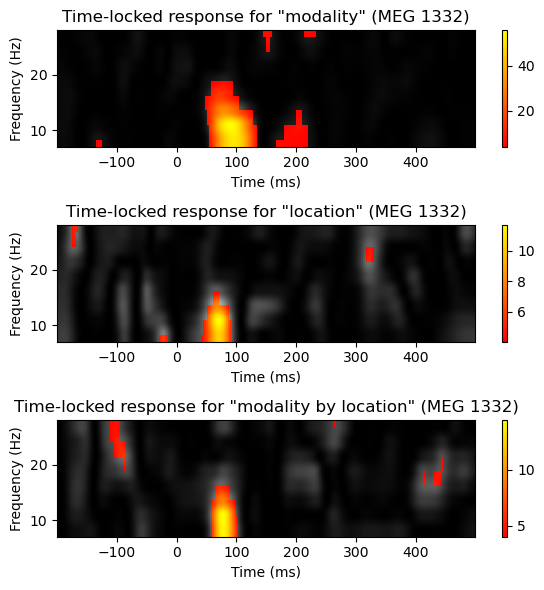

In [66]:
fvals, pvals = f_mway_rm(data, factor_levels, effects=effects)

effect_labels = ['modality', 'location', 'modality by location']

fig, axes = plt.subplots(3, 1, figsize=(6, 6))

# let's visualize our effects by computing f-images
for effect, sig, effect_label, ax in zip(fvals, pvals, effect_labels, axes):
    # show naive F-values in gray
    ax.imshow(effect, cmap='gray', aspect='auto', origin='lower',
              extent=[times[0], times[-1], freqs[0], freqs[-1]])
    # create mask for significant time-frequency locations
    effect[sig >= 0.05] = np.nan
    c = ax.imshow(effect, cmap='autumn', aspect='auto', origin='lower',
                  extent=[times[0], times[-1], freqs[0], freqs[-1]])
    fig.colorbar(c, ax=ax)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Time-locked response for "{effect_label}" ({ch_name})')

fig.tight_layout()

modify ANOVA using FDR vs permutation clustering test

In [67]:
effects = 'A:B'

In [68]:
def stat_fun(*args):
    return f_mway_rm(np.swapaxes(args, 1, 0), factor_levels=factor_levels,
                     effects=effects, return_pvals=False)[0]


# The ANOVA returns a tuple f-values and p-values, we will pick the former.
pthresh = 0.001  # set threshold rather high to save some time
f_thresh = f_threshold_mway_rm(n_replications, factor_levels, effects,
                               pthresh)
tail = 1  # f-test, so tail > 0
n_permutations = 256  # Save some time (the test won't be too sensitive ...)
F_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
    epochs_power, stat_fun=stat_fun, threshold=f_thresh, tail=tail,
    n_jobs=None, n_permutations=n_permutations, buffer_size=None,
    out_type='mask')

stat_fun(H1): min=0.000001 max=14.419588
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/255 [00:00<?,       ?it/s]

In [72]:
good_clusters = np.where(cluster_p_values < .05)[0]
F_obs_plot = F_obs.copy()
F_obs_plot[~clusters[np.squeeze(good_clusters)]] = np.nan

fig, ax = plt.subplots(figsize=(6, 4))
for f_image, cmap in zip([F_obs, F_obs_plot], ['gray', 'autumn']):
    c = ax.imshow(f_image, cmap=cmap, aspect='auto', origin='lower',
                  extent=[times[0], times[-1], freqs[0], freqs[-1]])

fig.colorbar(c, ax=ax)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Time-locked response for "modality by location" ({ch_name})\n'
             'cluster-level corrected (p <= 0.05)')
fig.tight_layout()

TypeError: only integer scalar arrays can be converted to a scalar index

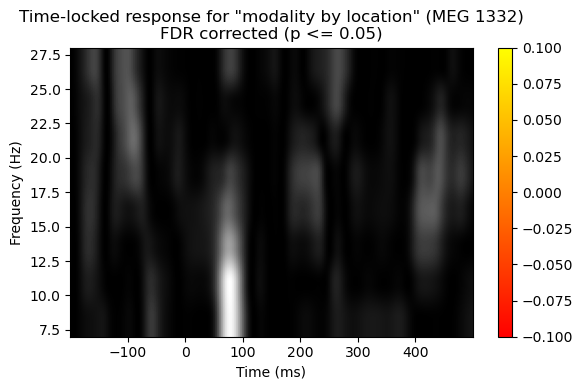

In [73]:
mask, _ = fdr_correction(pvals[2])
F_obs_plot2 = F_obs.copy()
F_obs_plot2[~mask.reshape(F_obs_plot.shape)] = np.nan

fig, ax = plt.subplots(figsize=(6, 4))
for f_image, cmap in zip([F_obs, F_obs_plot2], ['gray', 'autumn']):
    c = ax.imshow(f_image, cmap=cmap, aspect='auto', origin='lower',
                  extent=[times[0], times[-1], freqs[0], freqs[-1]])

fig.colorbar(c, ax=ax)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title(f'Time-locked response for "modality by location" ({ch_name})\n'
             'FDR corrected (p <= 0.05)')
fig.tight_layout()